# DeepLab

In [1]:
'''
IMPORTS
'''
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.image import resize, ResizeMethod
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import random
import os
import numpy as np
from numpy import load
import matplotlib.pyplot as plt

'''
DATA PATHS
'''
TOP_DIR = '/tf/Notebooks/Iwashita'

TRAIN_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment3/Train'
VAL_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment3/Validate'
TEST_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment3/Test'

'''
OUTPUTS PATH
'''
WEIGHTS_PATH = TOP_DIR + '/Output/Weights/'
METRICS_PATH = TOP_DIR + '/Output/Metrics/'

'''
GPU
'''
gpu_p40 = '/device:GPU:0'

get_ipython().system('nvidia-smi')

'''
TRAINING DATA
'''
exp3_rgb_X_train = load(TRAIN_DIR + '/exp3_rgb_X_train_dl.npy')
exp3_y_train = load(TRAIN_DIR + '/exp3_y_train_dl.npy')

'''
VALIDATION DATA
'''
exp3_rgb_X_val = load(VAL_DIR + '/exp3_rgb_X_val_dl.npy')
exp3_y_val = load(VAL_DIR + '/exp3_y_val_dl.npy')

'''
TEST DATA
'''
exp3_rgb_X_test_a = load(TEST_DIR + '/exp3_rgb_X_test_a_dl.npy')
exp3_y_test_a = load(TEST_DIR + '/exp3_y_test_a_dl.npy')

exp3_rgb_X_test_b = load(TEST_DIR + '/exp3_rgb_X_test_b_dl.npy')
exp3_y_test_b = load(TEST_DIR + '/exp3_y_test_b_dl.npy')

'''
INTERSECTION OVER UNION
'''
def iou(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]
    area_pred = np.histogram(y_pred, bins=num_classes)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    union[union == 0] = 1e-9
    iou = intersection / union

    return iou, np.mean(np.diag(iou))

'''
PIXEL ACCURACY
'''
def pixel_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.size

'''
MEAN ACCURACY
'''
def mean_accuracy(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]

    area_true[area_true == 0] = 1e-9
    accuracy = np.diag(intersection) / area_true

    return np.mean(accuracy)

'''
FREQUENCY-WEIGHTED INTERSECTION OVER UNION
'''
def fw_iou(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]
    area_pred = np.histogram(y_pred, bins=num_classes)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    union[union == 0] = 1e-9
    iou = intersection / union
    fw_iou = np.sum(area_true * iou) / np.sum(area_true)

    return fw_iou

def display_one_hot_annotation(annotations_onehot):
    label = np.argmax(annotations_onehot, axis=-1)
    cmap = plt.get_cmap('tab10', 7)

    plt.imshow(label, cmap=cmap)
    plt.colorbar(ticks=range(7), format=plt.FuncFormatter(lambda val, loc: {
        0: "unlabeled",
        1: "sand",
        2: "soil",
        3: "ballast",
        4: "rock",
        5: "bedrock",
        6: "rocky terrain"
    }[val]))
    plt.show()

print("Done")

2023-10-19 00:51:51.494085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Thu Oct 19 00:51:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:05:00.0 Off |                  Off |
| N/A   46C    P8    11W / 250W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
'''
MODEL PARAMS
'''
INPUT_DIMS = (572, 572, 3)

BATCH_SIZE = 4
EPOCHS = 1000 

LEARNING_RATE = 1e-4
PATIENCE = 15
FACTOR = 0.1

DROPOUT_RATE = 0.5

TRAINABLE_LAYERS = 300

LOSS_ = BinaryCrossentropy()
METRICS_ = [BinaryAccuracy()]

EXP3_FILENAME = "deeplab_exp3_batch{}_epoch{}_lr{}_p{}_f{}".format(
    BATCH_SIZE, EPOCHS, LEARNING_RATE, PATIENCE, FACTOR)

print("Done")

Done


2023-10-19 00:52:08.695819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 00:52:08.706060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 00:52:08.706433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### DeepLab Common

In [4]:
'''
Atrous Spatial Pyramid Pooling
'''
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLab(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet101 """
    base_model = ResNet101(weights='imagenet', include_top=False, input_tensor=inputs)
    
    for layer in base_model.layers[:TRAINABLE_LAYERS]:
        layer.trainable = False
    for layer in base_model.layers[TRAINABLE_LAYERS:]:
        layer.trainable = True

    """ Pre-trained ResNet101 Output """
    image_features = base_model.get_layer('conv4_block23_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    """ Spatial Pyramid Pooling (SPP) """
    # Apply different pooling sizes
    pool1 = GlobalAveragePooling2D()(x_a)
    pool2 = GlobalAveragePooling2D()(x_a)
    pool3 = GlobalAveragePooling2D()(x_a)

    # Concatenate pooled features
    spp_features = Concatenate()([pool1, pool2, pool3])

    # Reshape to match x_b's shape
    spp_features = tf.keras.layers.Reshape((1, 1, -1))(spp_features)
    spp_features = UpSampling2D((x_b.shape[1], x_b.shape[2]), interpolation="bilinear")(spp_features)

    x = Concatenate()([spp_features, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(DROPOUT_RATE)(x) 

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(DROPOUT_RATE)(x) 
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(7, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

'''
TRAIN
'''
def DeepLab_Train(model, X_train, y_train, X_val, y_val, weights_filename):
    
    try:
        with tf.device(gpu_p40):
            model.compile(
                optimizer=Adam(learning_rate=LEARNING_RATE), 
                loss=LOSS_, 
                metrics=METRICS_)
            
            callbacks = [
                ModelCheckpoint(weights_filename, save_best_only=True, save_weights_only=True, verbose=1),
                EarlyStopping(patience=PATIENCE, verbose=1),
                ReduceLROnPlateau(factor=FACTOR, patience=PATIENCE, min_lr=LEARNING_RATE, verbose=1)]
            
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, verbose=2)
            
    except RuntimeError as e:
        print(e)

'''
SCORE
'''
def DeepLab_Score(model, weights_filename, metrics_filename, X_test, y_test):
    
    try:
        with tf.device(gpu_p40):
            score = model.evaluate(X_test, y_test, batch_size=2, verbose=1)

    except RuntimeError as e:
        print(e)

    # Print and save the test metrics
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

    with open(metrics_filename, "a") as f:
        f.write(f"\Test Loss: {score[0]}\n")
        f.write(f"\Test Accuracy: {score[1]}\n")
        
'''
PREDICT
'''
def DeepLab_Predict(model, X_rgb_test):
    try:
        with tf.device(gpu_p40):
            pred = model.predict([X_rgb_test], batch_size=BATCH_SIZE)
            
    except RuntimeError as e:
        print(e)
        
    return pred

'''
DISPLAY RANDOM RESULT
'''
def DeepLab_Display(X_rgb_test, y_test, y_pred):

    try:
        with tf.device(gpu_p40):
            fig, axes = plt.subplots(1, 3, figsize=(10, 6))
            n = random.randint(0, len(X_rgb_test)-1)
            cmap = plt.get_cmap('tab10', 7)
    
            axes[0].imshow(X_rgb_test[n])
            axes[1].imshow(np.argmax(y_test[n], axis=-1), cmap=cmap)
            axes[2].imshow(np.argmax(y_pred[n], axis=-1), cmap=cmap)
                                           
            axes[0].set_title("RGB")
            axes[1].set_title("Annotation")
            axes[2].set_title("Predicted")
    
            for ax in axes.flatten():
                ax.axis("off")
        
            plt.tight_layout()
            plt.show()
            
    except RuntimeError as e:
        print(e)
'''
METRICS
'''
def DeepLab_Metrics(y_test, y_pred, metrics_filename):

    try:
        with tf.device(gpu_p40):
            y_pred_classes = np.argmax(y_pred, axis=-1)
            y_true_classes = np.argmax(y_test, axis=-1)
    
            num_classes=7

            iou_values, mean_iou = iou(y_true_classes, y_pred_classes, num_classes)
            pixel_acc = pixel_accuracy(y_true_classes, y_pred_classes)
            mean_acc = mean_accuracy(y_true_classes, y_pred_classes, num_classes)
            fw_iou_value = fw_iou(y_true_classes, y_pred_classes, num_classes)

            print(f"Mean IoU: {mean_iou}")
            print(f"Pixel accuracy: {pixel_acc}")
            print(f"Mean accuracy: {mean_acc}")
            print(f"Frequency-Weighted IoU: {fw_iou_value}")
    
            with open(metrics_filename, "a") as f:
                f.write("\nIoU Values:\n")
                for i, iou_val in enumerate(iou_values):
                    f.write(f"Class {i}: {iou_val}\n")
                f.write(f"\nMean IoU: {mean_iou}\n")
                f.write(f"Pixel Accuracy: {pixel_acc}\n")
                f.write(f"Mean Accuracy: {mean_acc}\n")
                f.write(f"Frequency Weighted IoU: {fw_iou_value}\n")
    except RuntimeError as e:
        print(e)

print("Done")

Done


In [5]:
'''
FILENAMES
'''
exp3_weights_filename = os.path.join(WEIGHTS_PATH, 'deeplab_baseline_exp3.h5')
exp3_metrics_filename = os.path.join(METRICS_PATH, 'deeplab_baseline_exp3.txt')

print("Done")

Done


In [6]:
'''
model
'''
try:
    with tf.device(gpu_p40):
        exp3_model = DeepLab(INPUT_DIMS)         
except RuntimeError as e:
    print(e)

print("Done")

Done


In [7]:
'''
TRAIN
'''
DeepLab_Train(
    exp3_model, exp3_rgb_X_train, exp3_y_train, exp3_rgb_X_val, exp3_y_val, exp3_weights_filename)

print("Done")

Epoch 1/1000


2023-10-19 00:52:28.769659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-19 00:52:29.922360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-19 00:52:33.097616: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x1d0a0690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-19 00:52:33.097672: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
2023-10-19 00:52:33.108227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-19 00:52:33.296151: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!


Epoch 1: val_loss improved from inf to 0.35108, saving model to /tf/Notebooks/Iwashita/Output/Weights/deeplab_baseline_exp3.h5
70/70 - 59s - loss: 0.4848 - binary_accuracy: 0.8807 - val_loss: 0.3511 - val_binary_accuracy: 0.8916 - lr: 1.0000e-04 - 59s/epoch - 838ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.35108 to 0.32834, saving model to /tf/Notebooks/Iwashita/Output/Weights/deeplab_baseline_exp3.h5
70/70 - 32s - loss: 0.3038 - binary_accuracy: 0.9099 - val_loss: 0.3283 - val_binary_accuracy: 0.9123 - lr: 1.0000e-04 - 32s/epoch - 461ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.32834 to 0.28751, saving model to /tf/Notebooks/Iwashita/Output/Weights/deeplab_baseline_exp3.h5
70/70 - 32s - loss: 0.2534 - binary_accuracy: 0.9220 - val_loss: 0.2875 - val_binary_accuracy: 0.9026 - lr: 1.0000e-04 - 32s/epoch - 459ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.28751 to 0.26081, saving model to /tf/Notebooks/Iwashita/Output/Weights/deeplab_baseline_exp3.h5
70/70


Epoch 35: val_loss improved from 0.10990 to 0.10785, saving model to /tf/Notebooks/Iwashita/Output/Weights/deeplab_baseline_exp3.h5
70/70 - 33s - loss: 0.1076 - binary_accuracy: 0.9618 - val_loss: 0.1079 - val_binary_accuracy: 0.9583 - lr: 1.0000e-04 - 33s/epoch - 465ms/step
Epoch 36/1000

Epoch 36: val_loss did not improve from 0.10785
70/70 - 31s - loss: 0.1092 - binary_accuracy: 0.9607 - val_loss: 0.1190 - val_binary_accuracy: 0.9550 - lr: 1.0000e-04 - 31s/epoch - 450ms/step
Epoch 37/1000

Epoch 37: val_loss did not improve from 0.10785
70/70 - 32s - loss: 0.1078 - binary_accuracy: 0.9618 - val_loss: 0.1084 - val_binary_accuracy: 0.9595 - lr: 1.0000e-04 - 32s/epoch - 450ms/step
Epoch 38/1000

Epoch 38: val_loss did not improve from 0.10785
70/70 - 31s - loss: 0.1084 - binary_accuracy: 0.9617 - val_loss: 0.1416 - val_binary_accuracy: 0.9512 - lr: 1.0000e-04 - 31s/epoch - 450ms/step
Epoch 39/1000

Epoch 39: val_loss did not improve from 0.10785
70/70 - 32s - loss: 0.1040 - binary_acc

Epoch 73/1000

Epoch 73: val_loss did not improve from 0.09653
70/70 - 32s - loss: 0.0832 - binary_accuracy: 0.9694 - val_loss: 0.1042 - val_binary_accuracy: 0.9614 - lr: 1.0000e-04 - 32s/epoch - 451ms/step
Epoch 74/1000

Epoch 74: val_loss did not improve from 0.09653
70/70 - 31s - loss: 0.0860 - binary_accuracy: 0.9688 - val_loss: 0.1115 - val_binary_accuracy: 0.9600 - lr: 1.0000e-04 - 31s/epoch - 450ms/step
Epoch 75/1000

Epoch 75: val_loss did not improve from 0.09653
70/70 - 32s - loss: 0.0864 - binary_accuracy: 0.9684 - val_loss: 0.1056 - val_binary_accuracy: 0.9618 - lr: 1.0000e-04 - 32s/epoch - 450ms/step
Epoch 76/1000

Epoch 76: val_loss did not improve from 0.09653
70/70 - 32s - loss: 0.0823 - binary_accuracy: 0.9701 - val_loss: 0.1035 - val_binary_accuracy: 0.9599 - lr: 1.0000e-04 - 32s/epoch - 450ms/step
Epoch 77/1000

Epoch 77: val_loss did not improve from 0.09653
70/70 - 31s - loss: 0.0805 - binary_accuracy: 0.9707 - val_loss: 0.0981 - val_binary_accuracy: 0.9635 - lr: 1

In [8]:
'''
SCORE
'''
print("Experiment 3a")
DeepLab_Score(
    exp3_model, exp3_weights_filename, exp3_metrics_filename, exp3_rgb_X_test_a, exp3_y_test_a)

print("\nExperiment 3b")
DeepLab_Score(
    exp3_model, exp3_weights_filename, exp3_metrics_filename, exp3_rgb_X_test_b, exp3_y_test_b)

print("Done")

Experiment 3a
216/216 [==============================] - 21s 88ms/step - loss: 0.2999 - binary_accuracy: 0.8897
Test loss: 0.299863338470459
Test accuracy: 0.8896988034248352

Experiment 3b
70/70 [==============================] - 6s 82ms/step - loss: 0.1076 - binary_accuracy: 0.9587
Test loss: 0.10756352543830872
Test accuracy: 0.9586740136146545
Done


In [9]:
'''
PREDICT
'''
print("Experiment 3a")
exp3_y_pred_a = DeepLab_Predict(exp3_model, exp3_rgb_X_test_a)

print("\nExperiment 3b")
exp3_y_pred_b = DeepLab_Predict(exp3_model, exp3_rgb_X_test_b)

print("Done")

Experiment 3a
108/108 [==============================] - 18s 149ms/step


2023-10-19 01:37:56.418146: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3948456512 exceeds 10% of free system memory.



Experiment 3b
35/35 [==============================] - 5s 147ms/step
Done


Experiment 3a


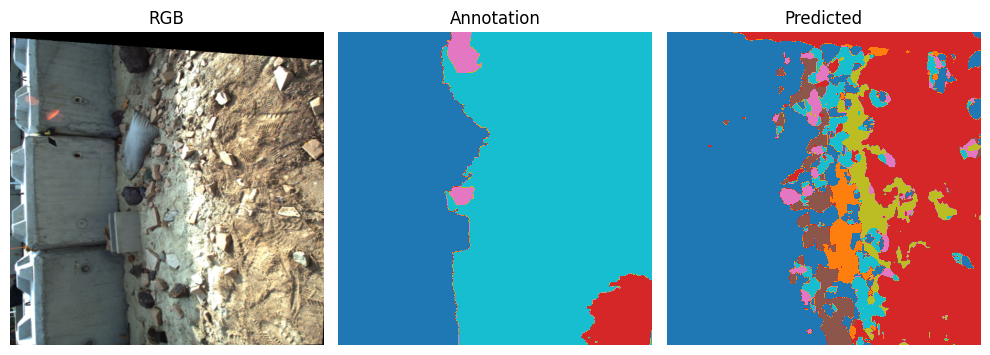


Experiment 3b


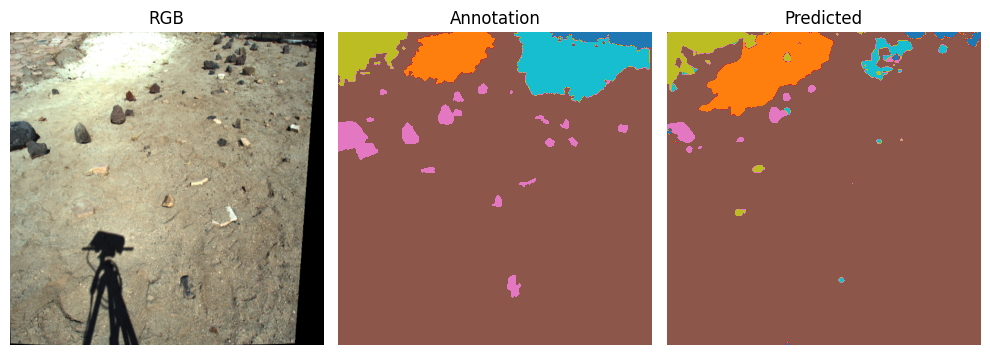

In [10]:
'''
DISPLAY RANDOM RESULT
'''
print("Experiment 3a")
DeepLab_Display(exp3_rgb_X_test_a, exp3_y_test_a, exp3_y_pred_a)

print("\nExperiment 3b")
DeepLab_Display(exp3_rgb_X_test_b, exp3_y_test_b, exp3_y_pred_b)

In [11]:
'''
METRICS
'''
print("Experiment 3a")
DeepLab_Metrics(exp3_y_test_a, exp3_y_pred_a, exp3_metrics_filename)

print("\nExperiment 3b")
DeepLab_Metrics(exp3_y_test_b, exp3_y_pred_b, exp3_metrics_filename)

Experiment 3a
Mean IoU: 0.32782663550507446
Pixel accuracy: 0.5919319584492868
Mean accuracy: 0.5194406427933117
Frequency-Weighted IoU: 0.660361704356865

Experiment 3b
Mean IoU: 0.6531611780846778
Pixel accuracy: 0.8530391592673061
Mean accuracy: 0.7507618992138708
Frequency-Weighted IoU: 0.8090188305107019
